# 教程5: 综合分析1

在本小节中，我将详细阐述我是怎么去分析，scRNA-seq注释与scATAC-seq注释的，包括分析过程中的代码以及思路。

不过需要注意的是，scATAC-seq在注释一些染色质在细胞成熟后几乎不打开的基因时是比较困难的。因为这类细胞不会分裂，死了就是死了，与常见的免疫细胞注释有区别。

In [3]:
#导入包
import anndata
print('anndata(Ver): ',anndata.__version__)
import scanpy as sc
print('scanpy(Ver): ',sc.__version__)
import matplotlib.pyplot as plt
import matplotlib
print('matplotlib(Ver): ',matplotlib.__version__)
import seaborn as sns
print('seaborn(Ver): ',sns.__version__)
import numpy as np
print('numpy(Ver): ',np.__version__)
import pandas as pd
print('pandas(Ver): ',pd.__version__)
import scvelo as scv
print('scvelo(Ver): ',scv.__version__)
import Pyomic
print('Pyomic(Ver): ',Pyomic.__version__)
import scvi
print('scvi(Ver): ',scvi.__version__)
import scglue
print('scglue(Ver): ',scglue.__version__)


#绘图参数设置
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

from matplotlib.colors import LinearSegmentedColormap
sc_color=['#7CBB5F','#368650','#A499CC','#5E4D9A','#78C2ED','#866017', '#9F987F','#E0DFED',
 '#EF7B77', '#279AD7','#F0EEF0', '#1F577B', '#A56BA7', '#E0A7C8', '#E069A6', '#941456', '#FCBC10',
 '#EAEFC5', '#01A0A7', '#75C8CC', '#F0D7BC', '#D5B26C', '#D5DA48', '#B6B812', '#9DC3C3', '#A89C92', '#FEE00C', '#FEF2A1']
sc_color_cmap = LinearSegmentedColormap.from_list('Custom', sc_color, len(sc_color))
current_path='/home/leihu/data/analysis/rb_tutorial/'

anndata(Ver):  0.8.0
scanpy(Ver):  1.9.1
matplotlib(Ver):  3.5.1
seaborn(Ver):  0.11.2
numpy(Ver):  1.22.3
pandas(Ver):  1.3.5
scvelo(Ver):  0.2.4
Pyomic(Ver):  1.1.4
scvi(Ver):  0.20.1
scglue(Ver):  0.3.2


## 1. 组学整合

在本小节，我们相将rna跟atac给拼起来，然后用拼好后的neighbor值作为后续leiden分析的基础，这样就成功将两个组学层给连到了一起。

In [5]:
rna=sc.read(current_path+'data/scglue/rna-emb.h5ad')
atac=sc.read(current_path+'data/scglue/atac-emb.h5ad')
rna,atac

(AnnData object with n_obs × n_vars = 20260 × 21705
     obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Tissue', 'Developmental_Stage', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'domain', 'leiden', 'balancing_weight'
     var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'End', 'Start', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'ID', 'copy_num_ID', 'coverage', 'db_xref', 'extra_copy_number', 'gbkey', 'gene', 'gene_biotype', 'gene_name', 'dell'
     uns: '__scglue__', 'hvg', 'leiden', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'scrublet', 'umap'
     obsm: 'X_glue', 'X_pca', 'X_umap'
     varm: 'PCs', 'X

In [6]:
#组学层命名
rna.obs['domain']='scRNA-seq'
atac.obs['domain']='scATAC-seq'

In [7]:
#合并组学层进行观察
combined = anndata.concat([rna, atac])
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)
combined

computing neighbors


2023-03-11 01:48:10.490835: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-11 01:48:10.490926: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-11 01:48:10.490932: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:19)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:32)


AnnData object with n_obs × n_vars = 41454 × 0
    obs: 'Tissue', 'Developmental_Stage', 'domain', 'balancing_weight'
    uns: 'neighbors', 'umap'
    obsm: 'X_glue', 'X_umap'
    obsp: 'distances', 'connectivities'

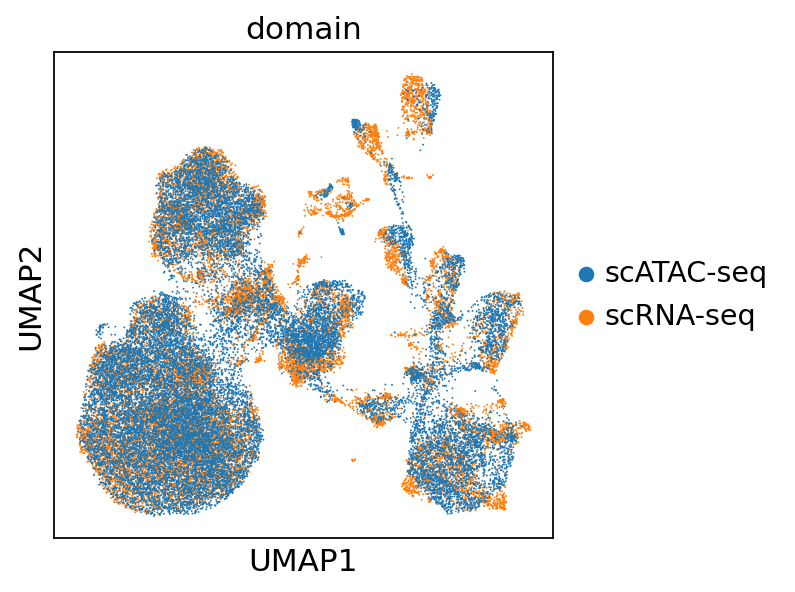

In [8]:
sc.pl.umap(combined, color=["domain"])

我们可以发现，scRNA-seq跟scATAC-seq的批次效应几乎被消除了

所以自然而然地想到，我们可以提取整合后的umap跟neighbor的结果

然后分配到rna跟atac文件中

In [9]:
#这里的五个复制还希望大家思考一下为什么是复制这五个，能不能少复制一些
rna.uns['neighbors']=combined[combined.obs['domain']=='scRNA-seq'].uns['neighbors']
rna.uns['umap']=combined[combined.obs['domain']=='scRNA-seq'].uns['umap']
rna.obsm['X_umap']=combined[combined.obs['domain']=='scRNA-seq'].obsm['X_umap']
rna.obsp['distances']=combined[combined.obs['domain']=='scRNA-seq'].obsp['distances']
rna.obsp['connectivities']=combined[combined.obs['domain']=='scRNA-seq'].obsp['connectivities']

atac.uns['neighbors']=combined[combined.obs['domain']=='scATAC-seq'].uns['neighbors']
atac.uns['umap']=combined[combined.obs['domain']=='scATAC-seq'].uns['umap']
atac.obsm['X_umap']=combined[combined.obs['domain']=='scATAC-seq'].obsm['X_umap']
atac.obsp['distances']=combined[combined.obs['domain']=='scATAC-seq'].obsp['distances']
atac.obsp['connectivities']=combined[combined.obs['domain']=='scATAC-seq'].obsp['connectivities']


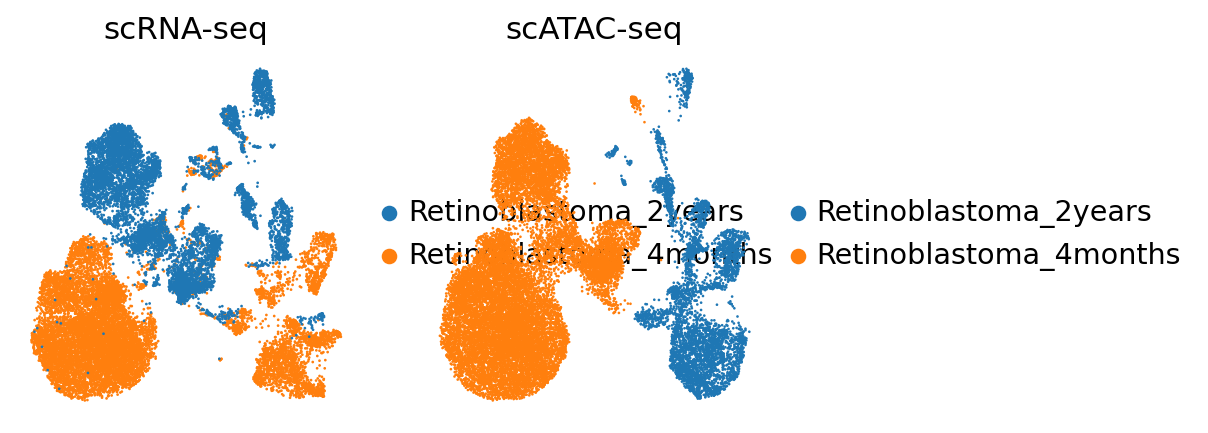

In [12]:
#还请大家思考，为什么这个代码我写了一个for循环，如果是你，你会怎么写
fig, axes = plt.subplots(1,2,figsize=(6,3))
for ad,title,ax_num in zip([rna,atac],['scRNA-seq','scATAC-seq'],[0,1]):
    ax=sc.pl.embedding(
        ad,
        basis="X_umap",
        color=['Developmental_Stage'],
        title=title,
        frameon=False,
        ncols=3,
        #save='_figure1_celltype.png',
        #use_raw=False,
        wspace=0.5,
        show=False,
        ax=axes[ax_num]
        #palette=sc_color[11:],
    )

我们保存一下这两个文件用于后续分析

In [13]:
atac.write_h5ad(current_path+'data/analysis1/atac_glue.h5ad',compression='gzip')
rna.write_h5ad(current_path+'data/analysis1/rna_glue.h5ad',compression='gzip')

## 2. RNA-seq细胞注释

我们得到的样本大多数为视网膜母细胞瘤细胞，我们可以用已有的视网膜母细胞瘤的字典来对rna-seq进行注释

同时，我们可以用marker基因对视网膜母细胞瘤细胞进行进一步注释，在这里，我们选择的文献是[Single-Cell Analysis of Human Retina Identifies Evolutionarily Conserved and Species-Specific Mechanisms Controlling Development](https://doi.org/10.1016/j.devcel.2020.04.009)

In [14]:
rna.X.max(),rna.X.min()
#我们发现rna的最大值跟最小值都不是整数，说明数据已经对数化过了

(142.33061, -5.90654)

由于我们数据里带有velocity的结果，所以我们可以考虑使用scvelo的函数进行高变基因的过滤，而不是使用scanpy的函数。

scvelo的具体使用说明请参照官方文档：https://scvelo.readthedocs.io/

In [15]:
rna.raw=rna
print('filter_genes')
scv.pp.filter_genes(rna, min_shared_counts=20)
#scv.pp.normalize_per_cell(adata)
print('filter_genes_dispersion')
scv.pp.filter_genes_dispersion(rna, n_top_genes=2000)
#scv.pp.log1p(adata)
print('moments')
scv.pp.moments(rna, n_pcs=30, n_neighbors=30)

filter_genes
Filtered out 9137 genes that are detected 20 counts (shared).
filter_genes_dispersion
Extracted 2000 highly variable genes.
moments
Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:07) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [16]:
#我们之前整合的时候已经计算过邻域neighbor了，所以这里直接算leiden就好
sc.tl.leiden(rna)

running Leiden clustering
    finished: found 28 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


In [17]:
#同时我们把小于100个细胞的leiden给过滤掉
print(rna.obs['leiden'].value_counts()[rna.obs['leiden'].value_counts()<100].index)
rna=rna[~rna.obs['leiden'].isin(rna.obs['leiden'].value_counts()[rna.obs['leiden'].value_counts()<100].index)]
rna

CategoricalIndex(['23', '24', '25', '26', '27'], categories=['0', '1', '2', '3', '4', '5', '6', '7', ...], ordered=False, dtype='category')


View of AnnData object with n_obs × n_vars = 20105 × 2000
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Tissue', 'Developmental_Stage', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'domain', 'leiden', 'balancing_weight', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'End', 'Start', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'ID', 'copy_num_ID', 'coverage', 'db_xref', 'extra_copy_number', 'gbkey', 'gene', 'gene_biotype', 'gene_name', 'dell', 'dispersions', 'dispersions_norm'
    uns: '__scglue__', 'hvg', 'leiden', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'scrublet', 'umap', 'Develop

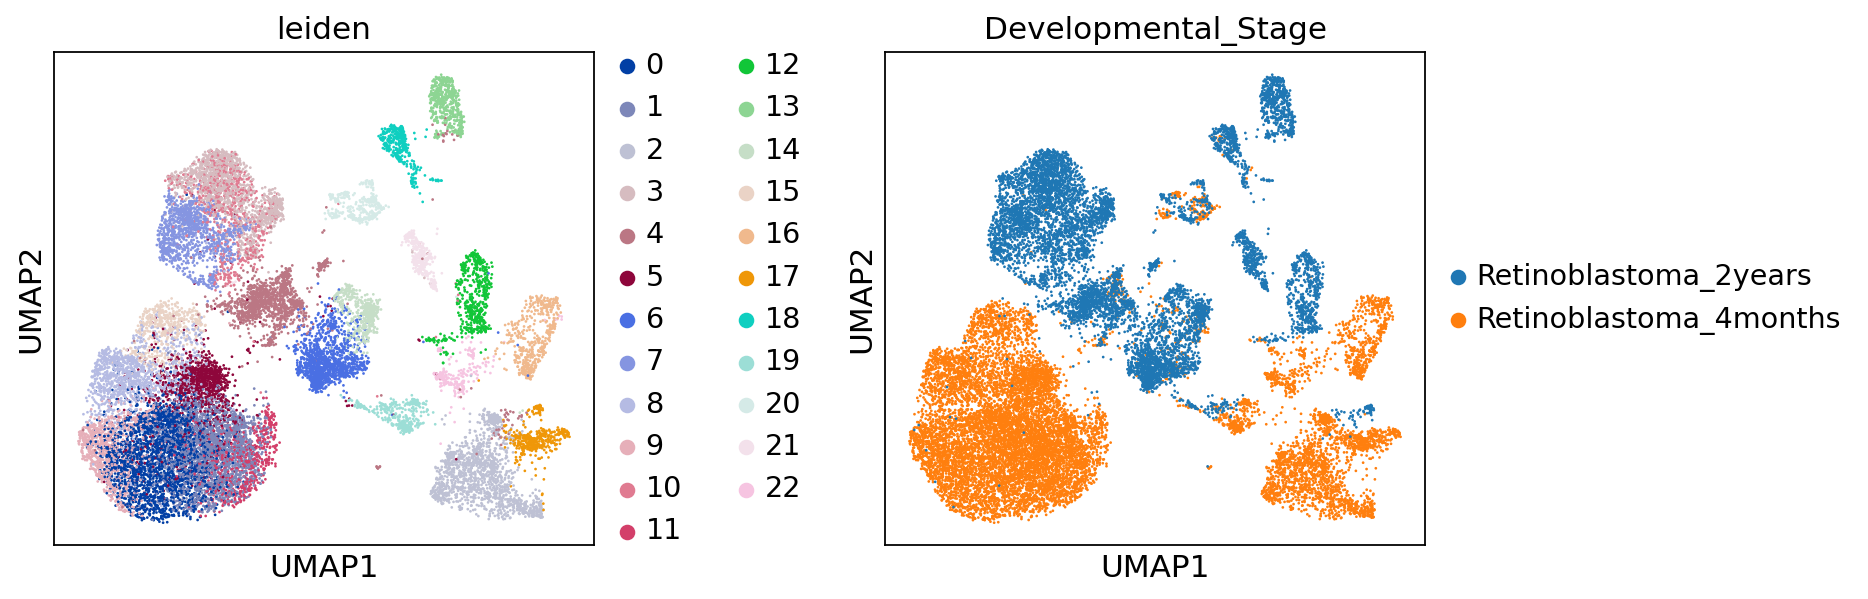

In [19]:
sc.pl.umap(rna,color=['leiden','Developmental_Stage'],wspace=0.4)

我们从文献中，归纳了作者用到的marker成为字典

In [20]:
marker_genes_dict_manu = {
    'RPCs': ['CCND1','VIM'],#视网膜感光细胞 retinal progenitor cell
    'RGCs': ['CKB','STMN1',],#神经节细胞 retinal ganglion cell
    'RECs': ['PTPRB','PECAM1'],#retinal endothelial cells
    'Ganglion cells':['GAP43','ELAVL4'],#视网膜神经细胞 
    'Horizontal cells':['ONECUT2','TFAP2A','ESRRB'],#水平细胞
    'Cone cells':['ISL2','LMO4','ARR3','GUCA1C'],#视锥细胞
    'Bipolar cells':['VSX1','PRDM8'],#双极细胞
    'Muller cells':['CLU','RLBP1'],#神经胶质细胞
    'Amacrine cells':['GAD1'],#无长突细胞
    'Glial cells':['S100A6','CLDN4'],# 胶质细胞
    'Rods':['GNAT1','NR2E3','RAX2','NRL']#视杆细胞
}

    using 'X_pca' with n_pcs = 100
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: RPCs, RGCs, RECs, etc.


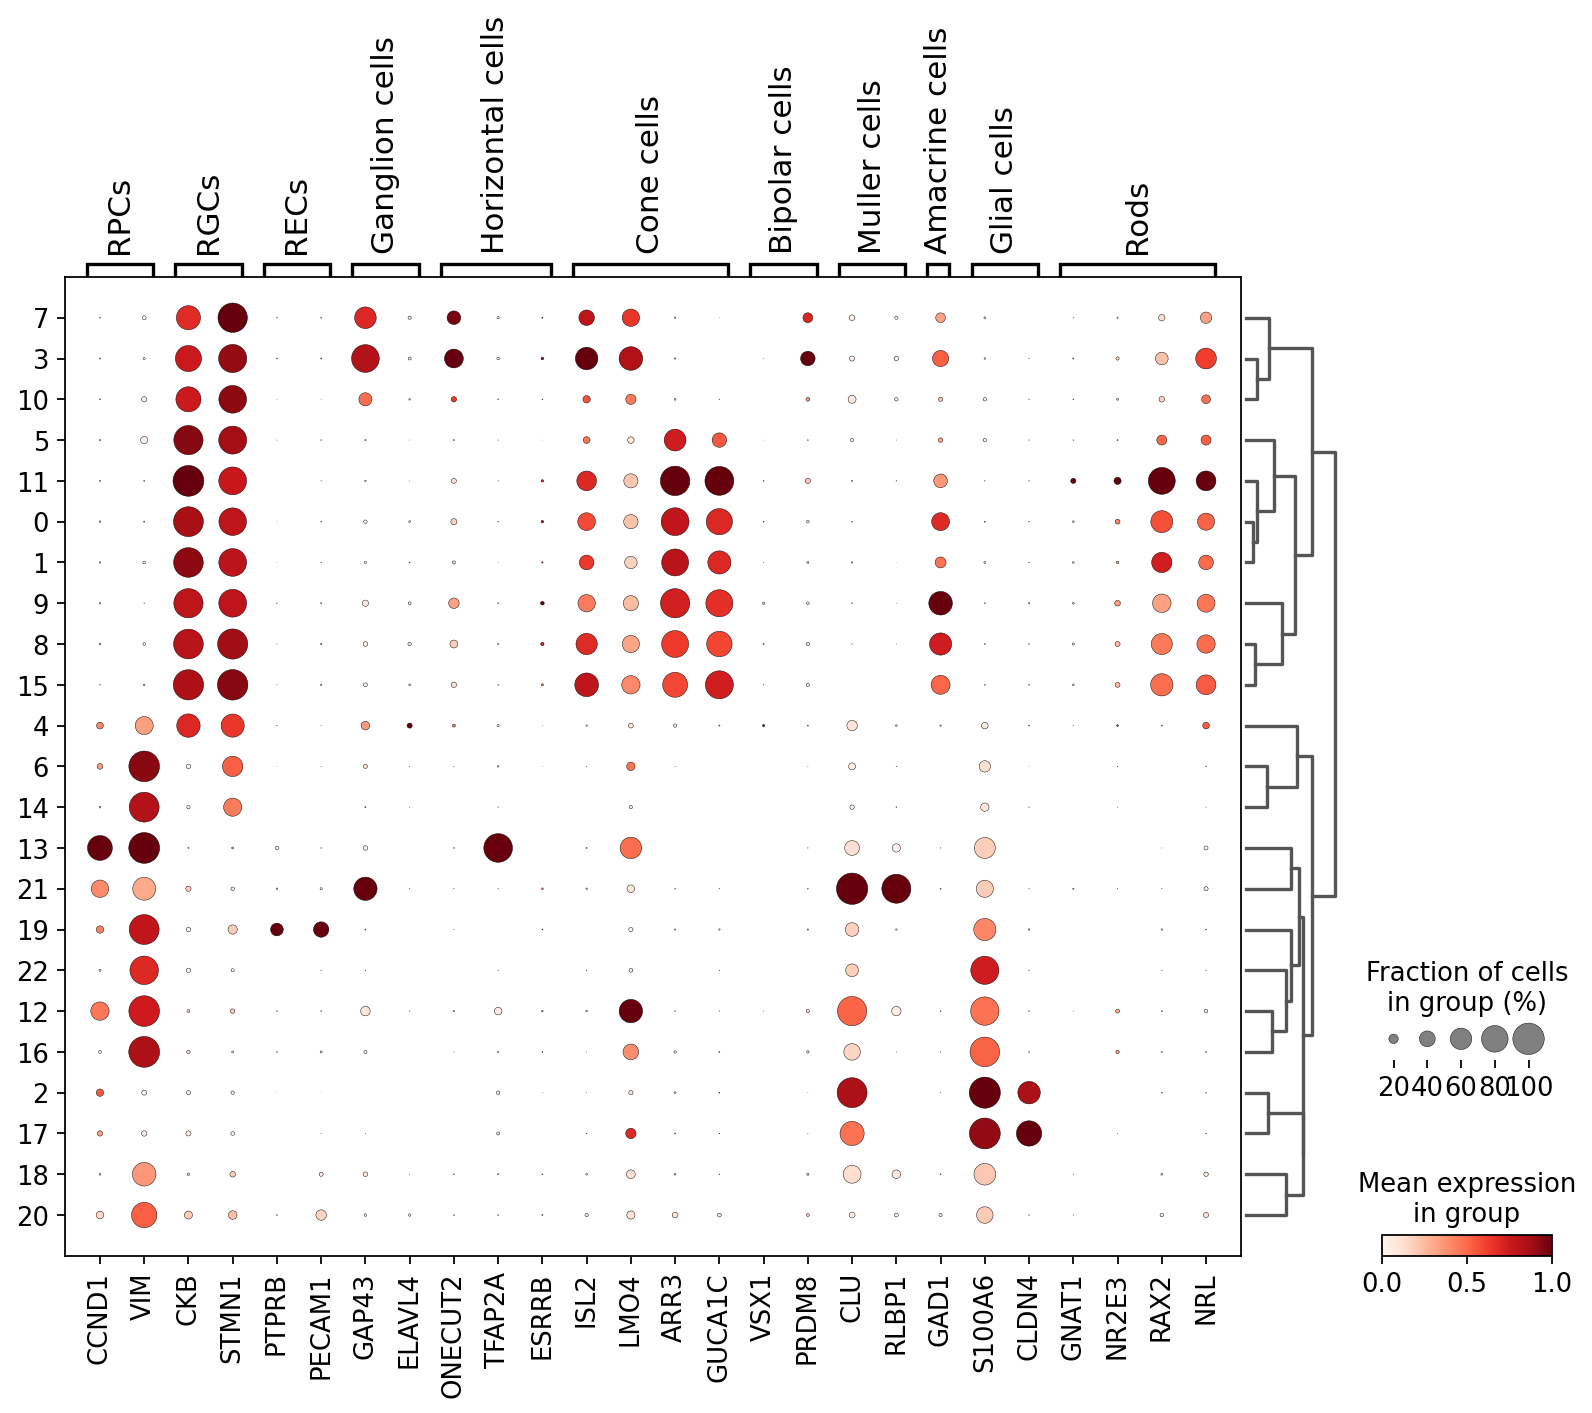

In [21]:
sc.pl.dotplot(rna, marker_genes_dict_manu, 'leiden', dendrogram=True,standard_scale='var')

此外，我们用ChatGPT生成了一个字典

In [22]:
retina_dict_chatgpt = {
    'Photoreceptor cells': ['RHO', 'CRX', 'RCVRN', 'SAG'],
    'Bipolar cells': ['PRKCA', 'NRGN', 'TH', 'CCK'],
    'Horizontal cells': ['CALB1', 'GABRA1', 'PRKCA'],
    'Amacrine cells': ['SLC6A1', 'CALB2', 'SLC6A9', 'SST'],
    'Retinal ganglion cells': ['POU4F1', 'THY1', 'NEFL', 'TUBB3', 'ISL1', 'ATOH7'],
    'Müller glia cells': ['GLUL', 'VIM', 'RLBP1', 'CSPG4'],
    'Rod photoreceptor cells': ['RHO', 'CNGB1', 'GNAT1', 'SAG'],
    'Cone photoreceptor cells': ['CRX', 'OPN1LW', 'OPN1MW', 'OPN1SW', 'GNAT2'],
    'Retinal pigment epithelium (RPE) cells': ['BEST1', 'RLBP1', 'RPE65', 'TYR'],
    'Microglia cells': ['IBA1', 'CD68',  'TREM2'],
    'Astrocytes': ['GFAP', 'S100B', 'AQP4', 'GJA1'],
    'Retinal progenitor cells (RPCs)': ['PAX6', 'NESTIN', 'SOX2', 'VSX2'],
    'Pericytes': ['PDGFRB', 'ACTA2', 'CD13', 'RGS5'],
    'Myeloid cells': ['CD45',  'CD68', 'CD163']
}
#由于我们找到的marker基因可能不在数据集中，所以我们需要对字典与我们的adata.var取交集
all_genes=rna.raw.var.index.tolist()
for key in retina_dict_chatgpt.keys():
    for gene in retina_dict_chatgpt[key]:
        if gene not in all_genes:
            retina_dict_chatgpt[key].remove(gene)
retina_dict_chatgpt         

{'Photoreceptor cells': ['RHO', 'CRX', 'RCVRN', 'SAG'],
 'Bipolar cells': ['PRKCA', 'NRGN', 'TH', 'CCK'],
 'Horizontal cells': ['CALB1', 'GABRA1', 'PRKCA'],
 'Amacrine cells': ['SLC6A1', 'CALB2', 'SLC6A9', 'SST'],
 'Retinal ganglion cells': ['POU4F1',
  'THY1',
  'NEFL',
  'TUBB3',
  'ISL1',
  'ATOH7'],
 'Müller glia cells': ['GLUL', 'VIM', 'RLBP1', 'CSPG4'],
 'Rod photoreceptor cells': ['RHO', 'CNGB1', 'GNAT1', 'SAG'],
 'Cone photoreceptor cells': ['CRX', 'OPN1LW', 'OPN1MW', 'OPN1SW', 'GNAT2'],
 'Retinal pigment epithelium (RPE) cells': ['BEST1', 'RLBP1', 'RPE65', 'TYR'],
 'Microglia cells': ['CD68', 'TREM2'],
 'Astrocytes': ['GFAP', 'S100B', 'AQP4', 'GJA1'],
 'Retinal progenitor cells (RPCs)': ['PAX6', 'SOX2', 'VSX2'],
 'Pericytes': ['ACTA2', 'RGS5'],
 'Myeloid cells': ['CD68', 'CD163']}

    using 'X_pca' with n_pcs = 100
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: Photoreceptor cells, Bipolar cells, Horizontal cells, etc.


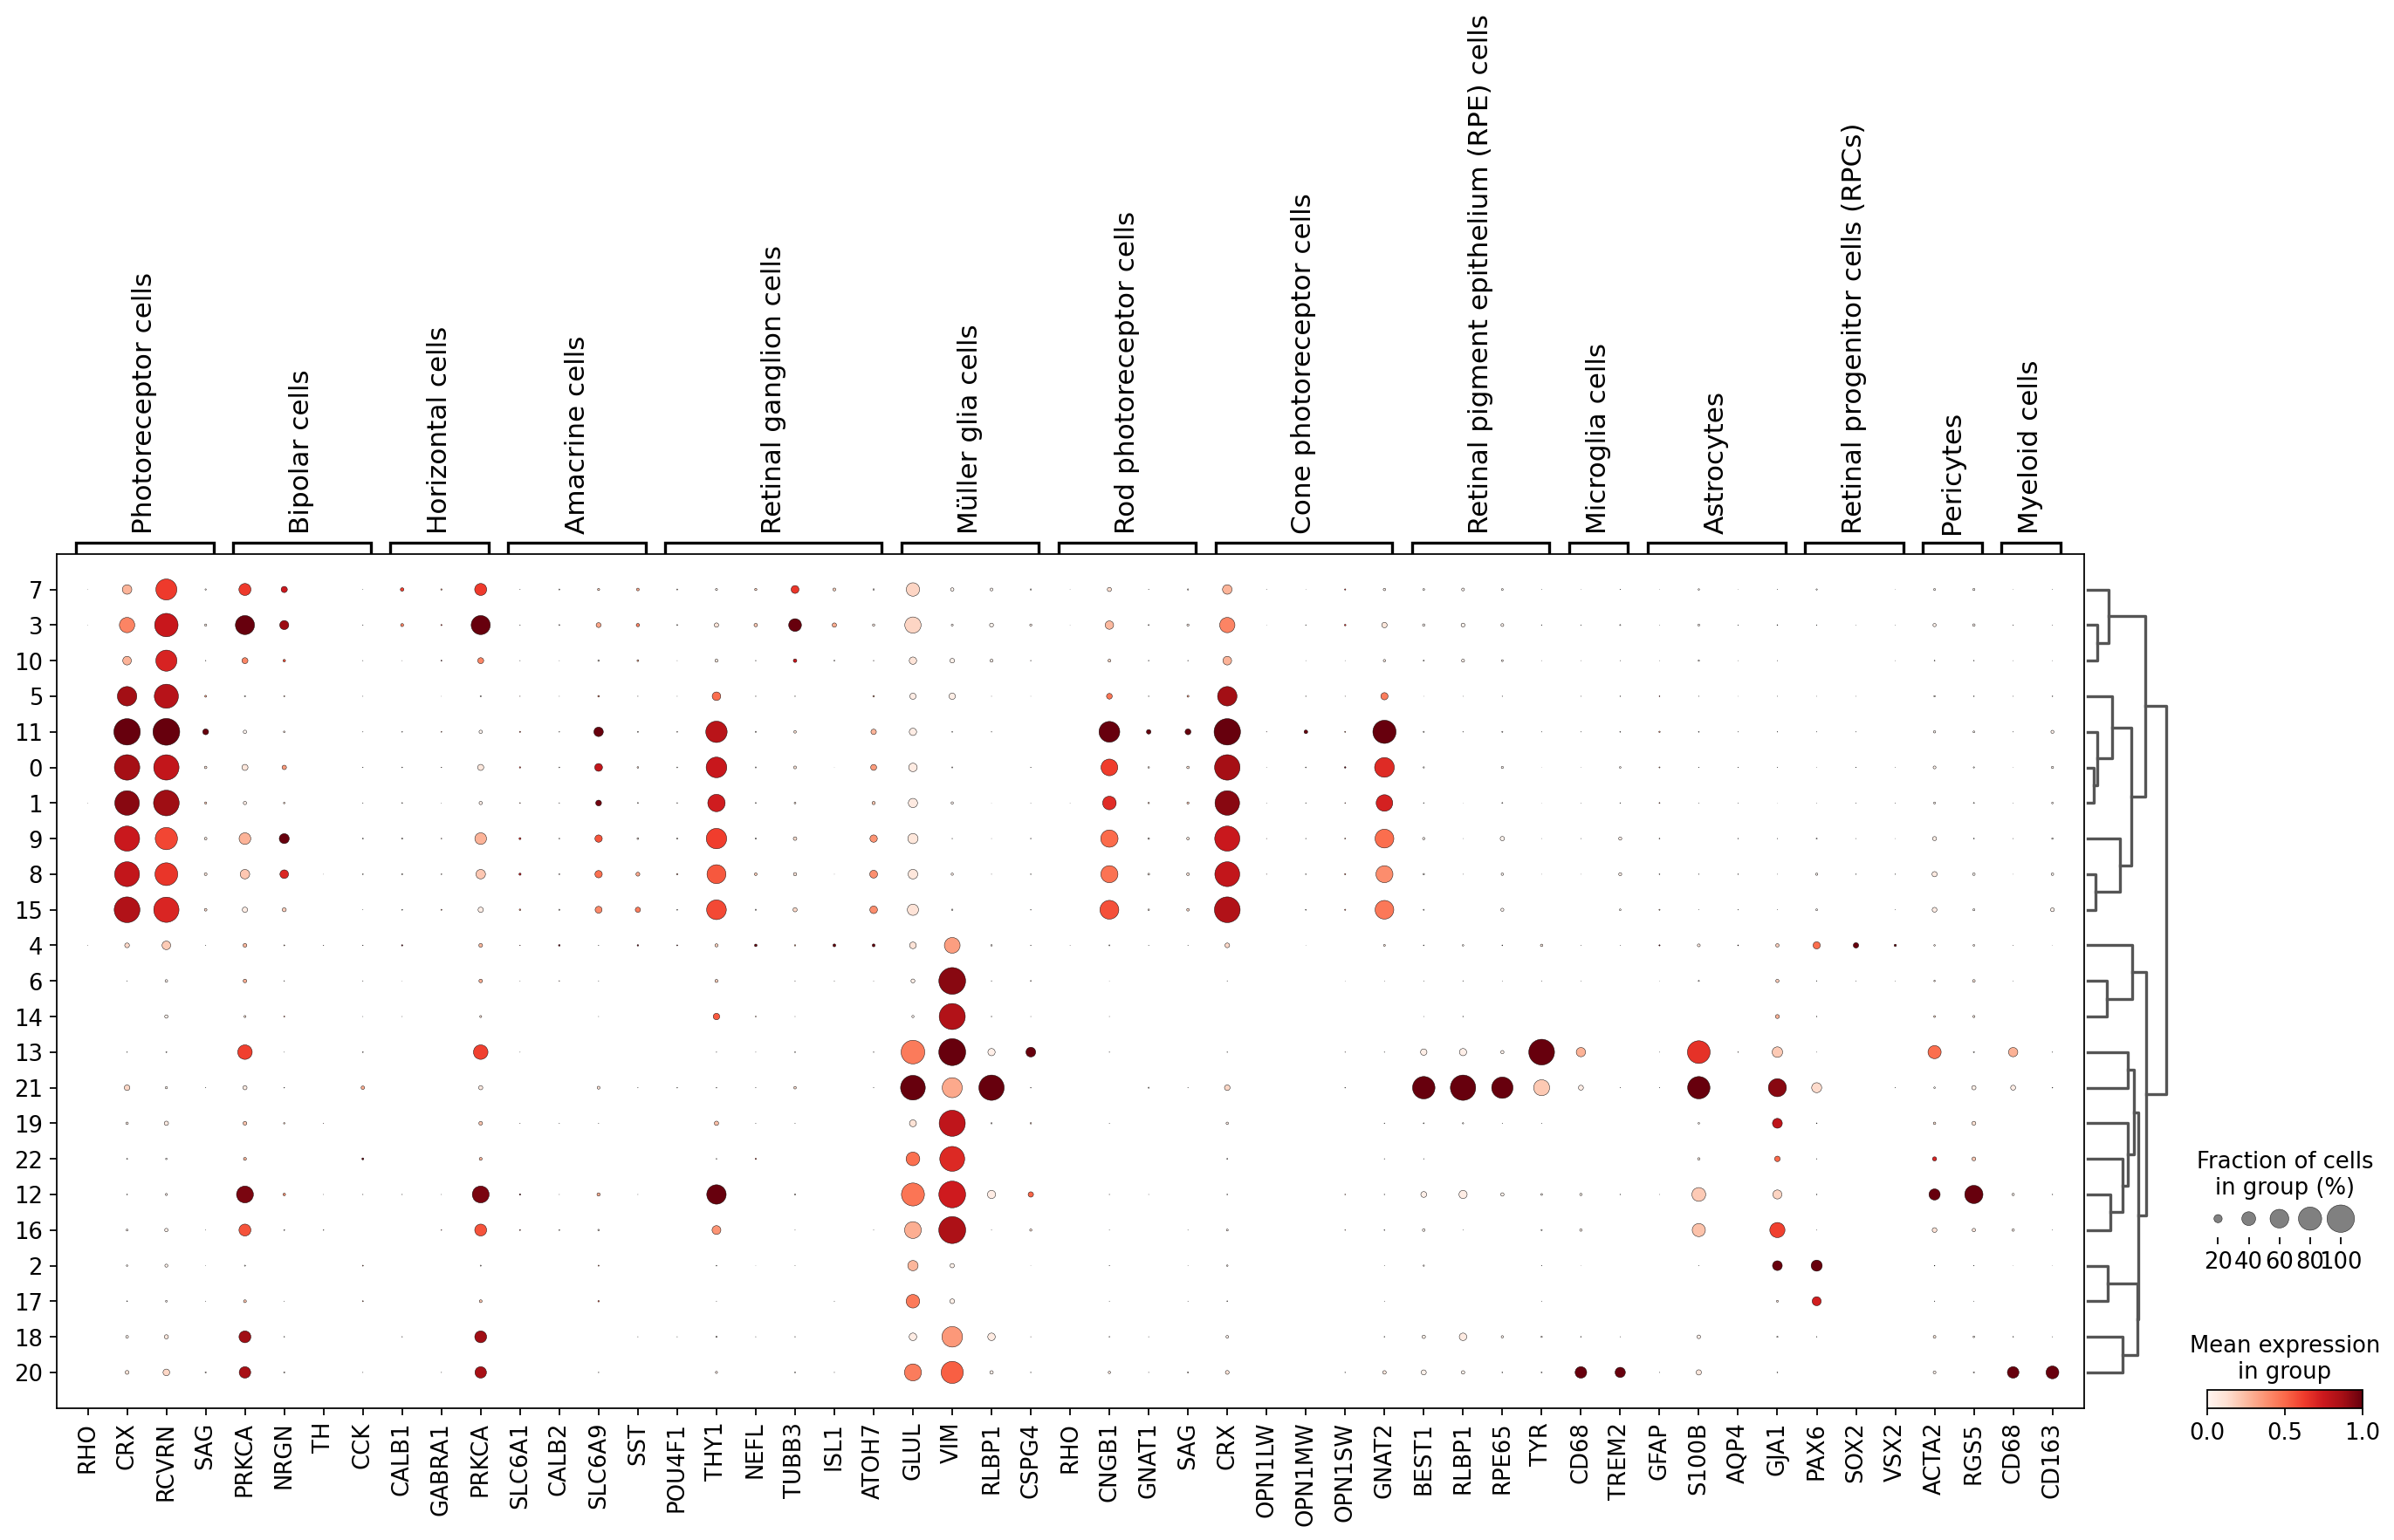

In [23]:
sc.tl.dendrogram(rna,'leiden')
sc.pl.dotplot(rna, retina_dict_chatgpt, 'leiden', dendrogram=True,standard_scale='var')

对比两个字典的结果我们发现，在大类的注释中，根据文献的结果我们可以得到RGCs和RPC两个大类，而根据ChatGPT的结果，我们可以得到感光细胞（Photoreceptor）和胶质细胞（Muller glia）两个大类。

对比文献的字典跟chatgpt的字典，我感觉有一个在放屁，所以我们查一下vim到底是哪个细胞类型中表达，然后发现，文献在放屁，VIM在RPCs中不怎么表达，在穆勒胶质细胞中高表达，这意味着ChatGPT的结果是正确的，文献可能是错误的。

为了准确注释细胞类型，我们需要对leiden的marker基因进行功能查询


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:18)


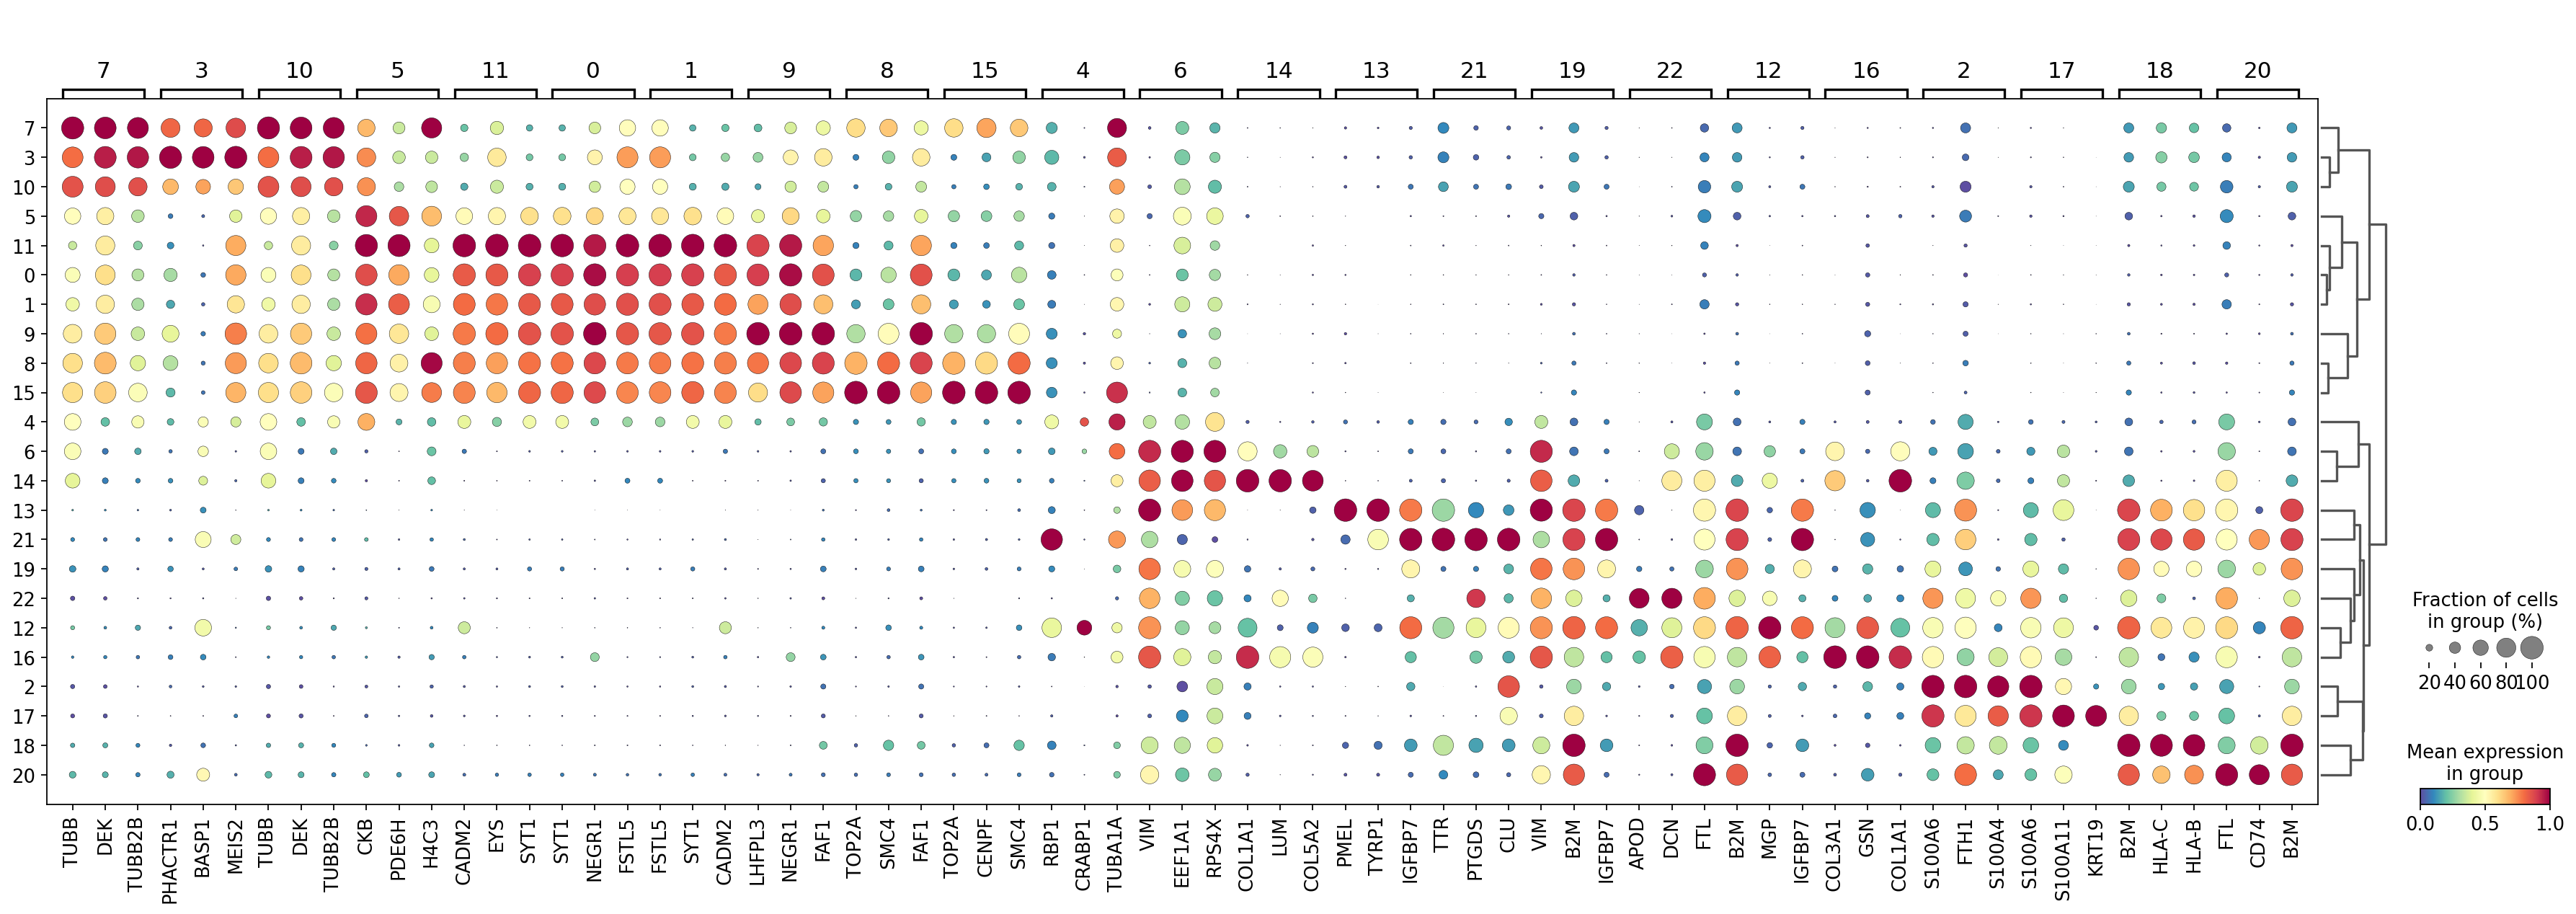

In [24]:
#我们顺便计算了clusters的marker基因
rna.uns['log1p']['base']=None
sc.tl.rank_genes_groups(rna, 'leiden', method='t-test')
sc.pl.rank_genes_groups_dotplot(rna,groupby='leiden',
                                cmap='Spectral_r',
                                standard_scale='var',n_genes=3)

**finished identifying marker genes by COSG**


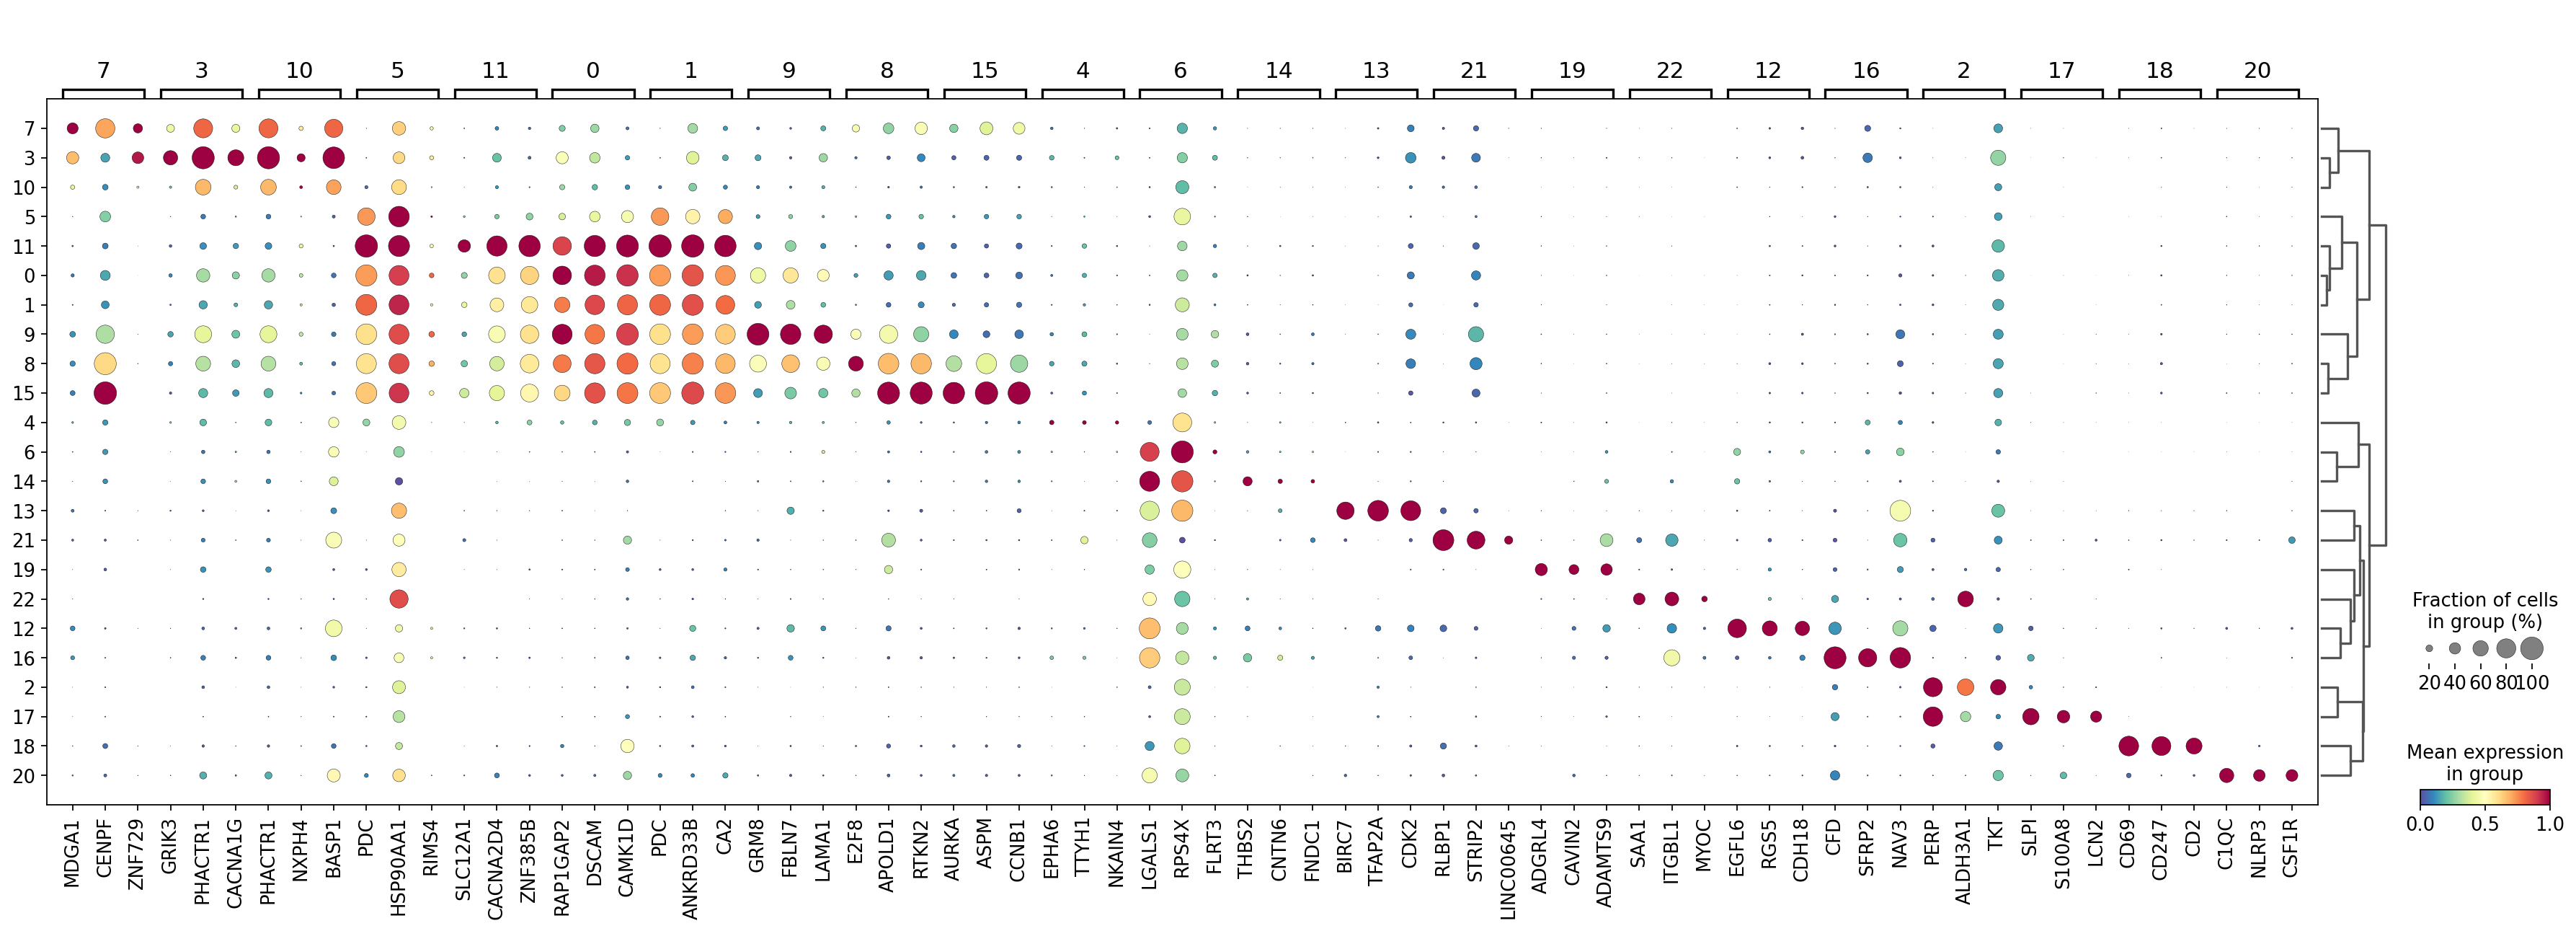

In [25]:
#在这里我们采用两种不同的方法，COSG也是一个好的策略
Pyomic.single.cosg(rna, key_added='cosg', groupby='leiden')
#cosg
sc.pl.rank_genes_groups_dotplot(rna,groupby='leiden',
                                cmap='Spectral_r',key='cosg',
                                standard_scale='var',n_genes=3)

    using 'X_pca' with n_pcs = 100
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: Tumor, Mesangial cell, Endothelium(VCAM1-), etc.


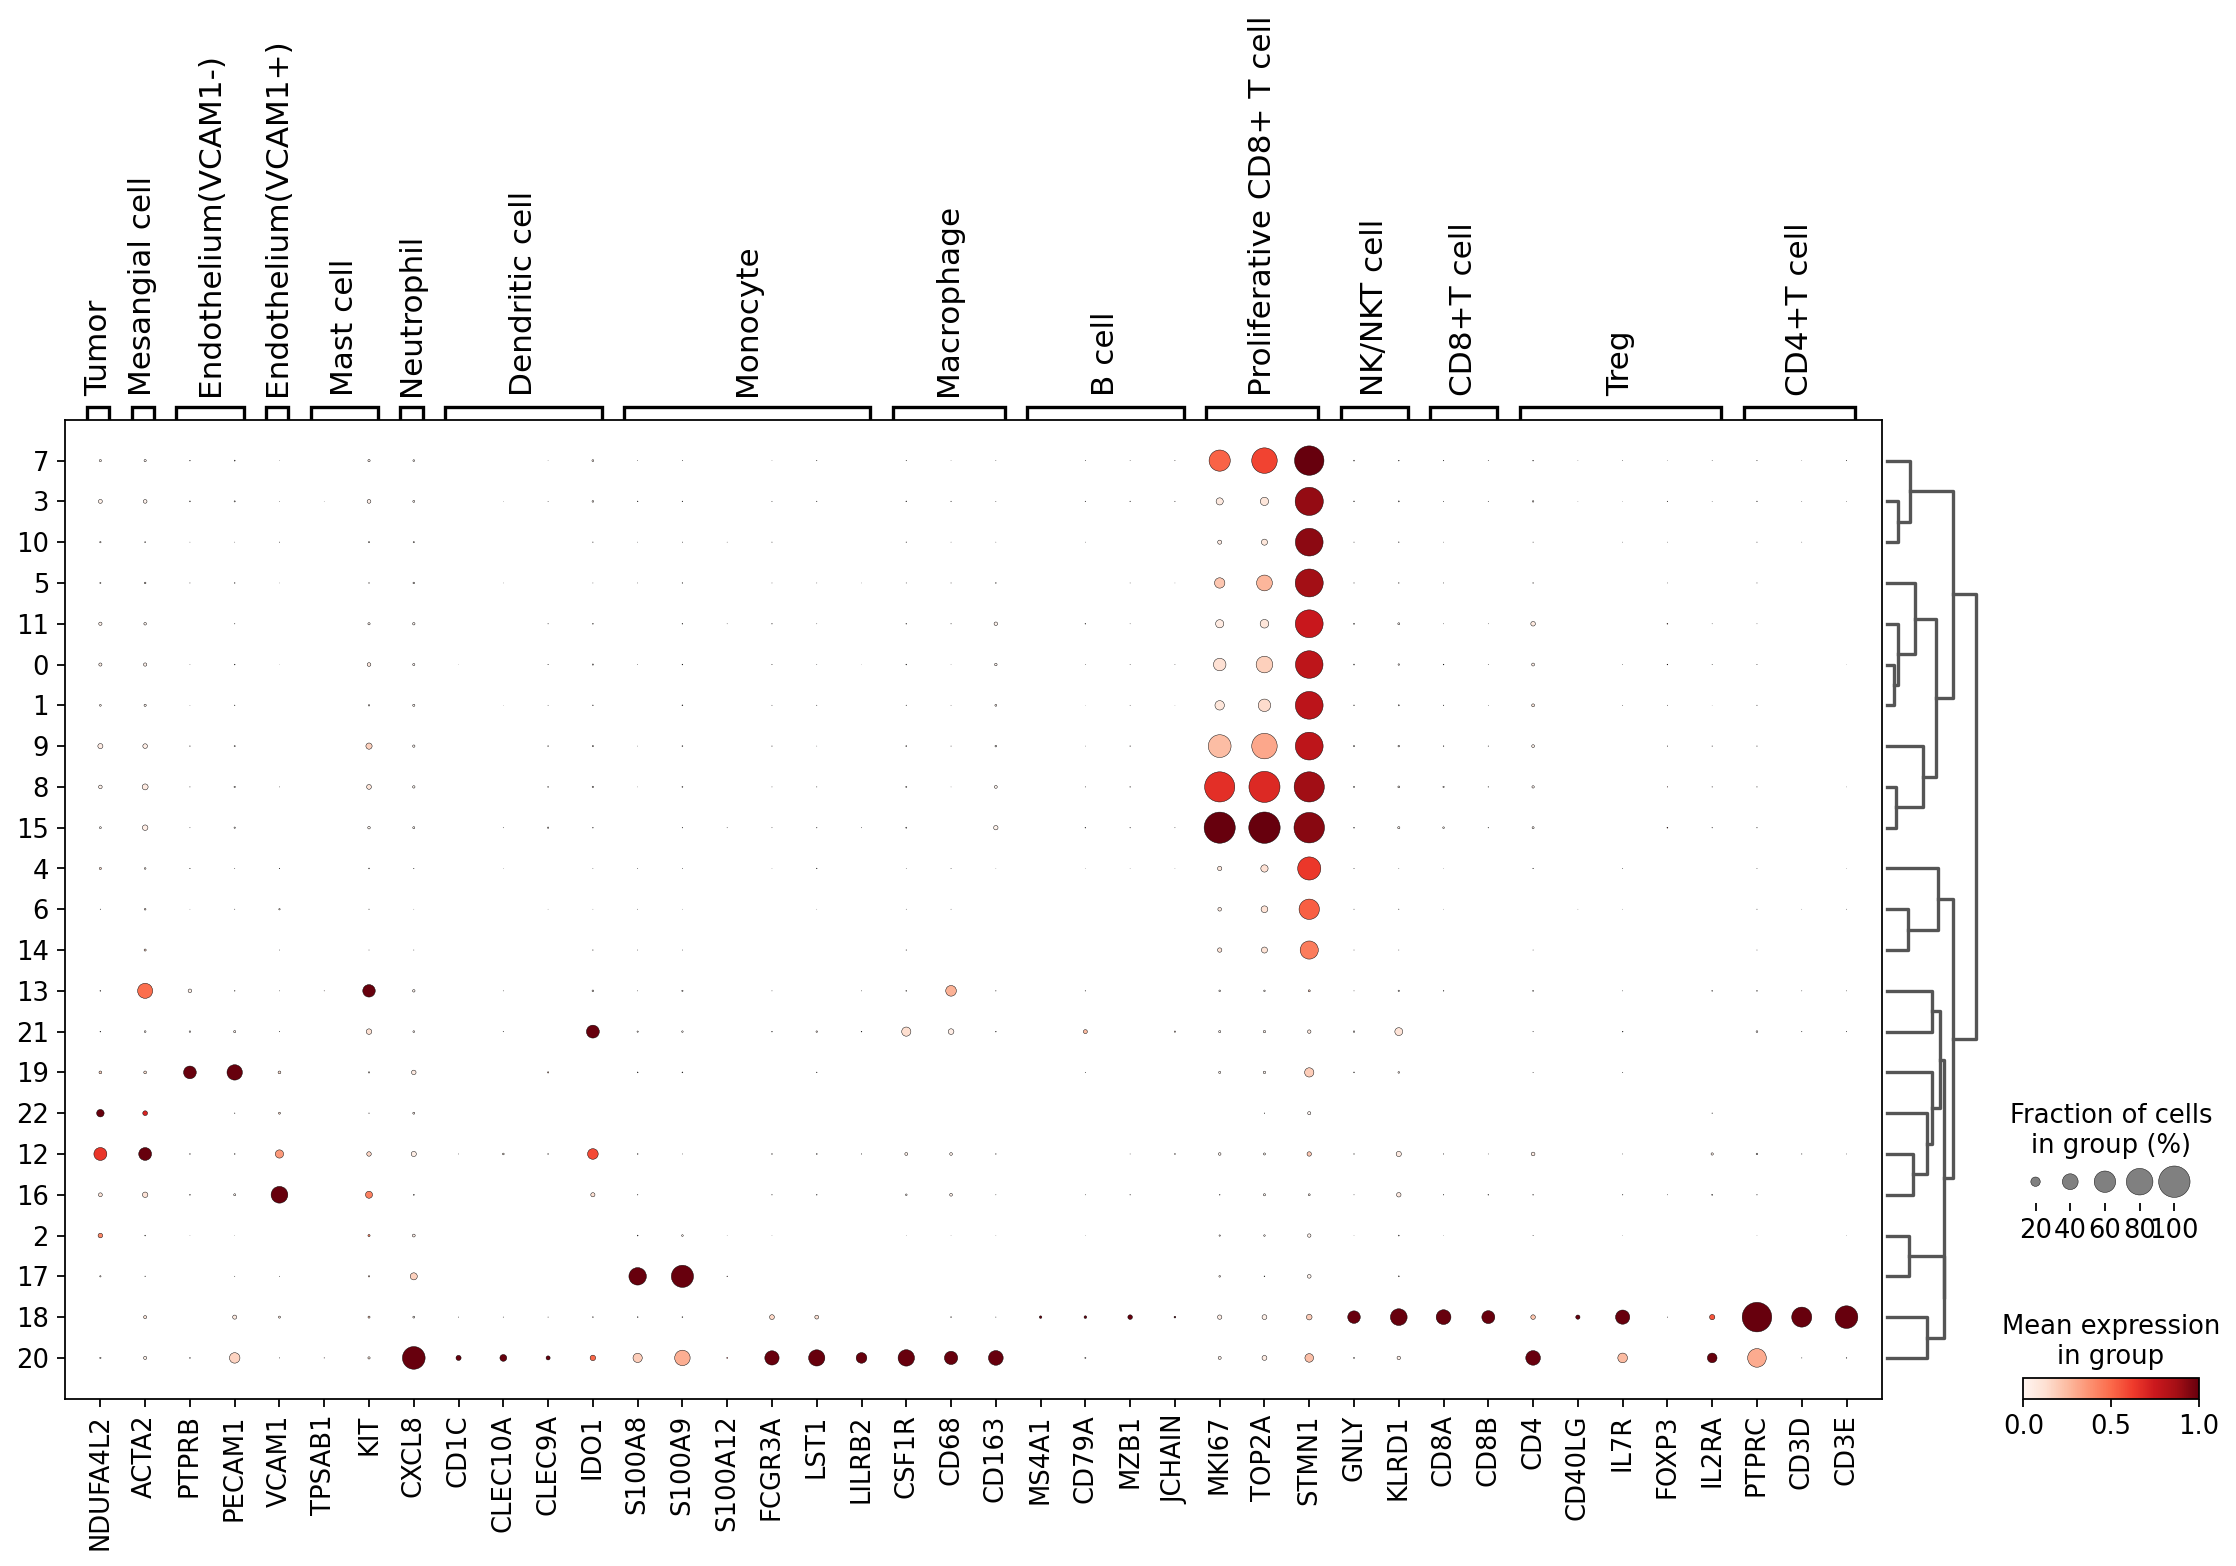

In [26]:
#同时我们还应观察免疫细胞的表达情况
res_marker_dict={
    'Tumor':['NDUFA4L2'],
    'Mesangial cell':['ACTA2'],
    'Endothelium(VCAM1-)':['PTPRB','PECAM1'],
    'Endothelium(VCAM1+)':['VCAM1'],
    'Mast cell':['TPSAB1','KIT'],
    'Neutrophil' :['CXCL8',],
    'Dendritic cell':['CD1C','CLEC10A','CLEC9A','IDO1'],
    'Monocyte' :['S100A8','S100A9','S100A12','FCGR3A','LST1','LILRB2'],
    'Macrophage':['CSF1R','CD68','CD163'],
    'B cell':['MS4A1','CD79A','MZB1','JCHAIN'],
    'Proliferative CD8+ T cell':['MKI67','TOP2A','STMN1'],
    'NK/NKT cell':['GNLY','KLRD1'],
    'CD8+T cell':['CD8A','CD8B'],
    'Treg':['CD4','CD40LG','IL7R','FOXP3','IL2RA'],
    'CD4+T cell':['PTPRC','CD3D','CD3E'],
}
sc.tl.dendrogram(rna,'leiden')
sc.pl.dotplot(rna, res_marker_dict, 'leiden', dendrogram=True,standard_scale='var')

经过chatGPT不断研究每一个leiden的marker基因，以及umap图上细胞的位置，leiden=4的cluster没有特定的marker，但是其在所有细胞的中间，所以它可能是神经母细胞
我们将其命名为视网膜干细胞Retinal stem cells

此外我们还发现了一类细胞高表达TPH1和TFF1，我们将这类细胞命名为`Serotonin- and Trefoil factor-expressing Retinal (STER) cell`，我们猜测其有着不一般的功能

In [47]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'Photoreceptor cells',
     '1': 'Photoreceptor cells',
     '2': 'Astrocytes',#Germ-cell(Oid)
     '3': 'STER cells',#Germ-cell(Oid)
     '4': 'Retinal stem cells',
     '5': 'Photoreceptor cells',
     '6': 'Müller glia cells',
     '7': 'STER cells',
     '8': 'P-Photoreceptor cells',
     '9': 'Photoreceptor cells',
     '10': 'STER cells',#Germ-cell(Oid)
     '11': 'Photoreceptor cells',
     '12': 'Müller glia cells',
     '13': 'Lymphocytes',
     '14': 'Müller glia cells',
     '15': 'P-Photoreceptor cells',#Germ
     '16': 'Müller glia cells',#plasma
     '17': 'Astrocytes',#plasma
     '18': 'Lymphocytes',
     '19': 'Müller glia cells',
     '20': 'Lymphocytes',#Germ-cell(Oid)
     '21': 'RPE cells',
     '22': 'Müller glia cells',


}
rna.obs['major_celltype'] = rna.obs['leiden'].map(cluster2annotation).astype('category')

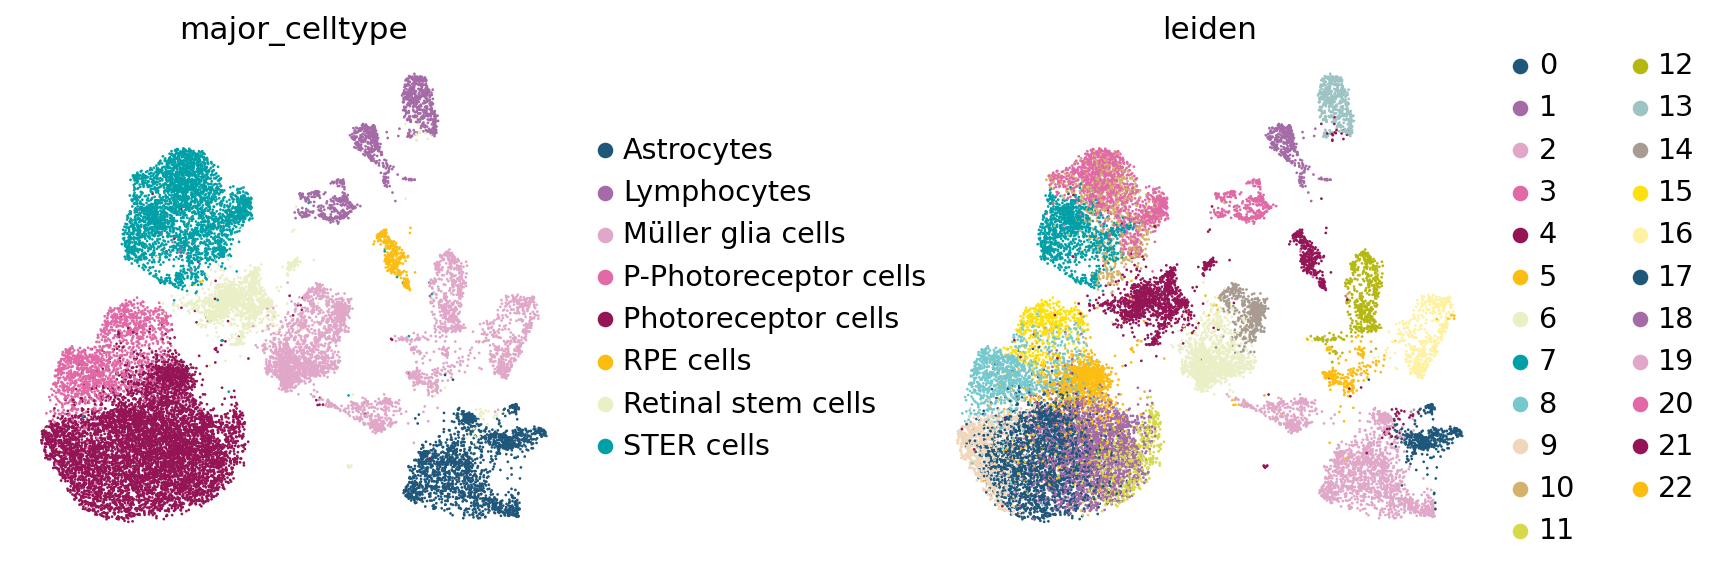

In [49]:
ax=sc.pl.embedding(
    rna,
    basis="X_umap",
    color=['major_celltype','leiden'],
    #title='scRNA-seq',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    wspace=0.5,
    show=False,
    palette=sc_color[11:],
)

经过一段时间的艰难查询marker基因，我们终于把细胞给注释完了，接下来，我们把相关的细胞注释结果迁移到scATAC层

In [51]:
sc.pp.neighbors(atac, use_rep="X_glue", metric="cosine",n_neighbors=15, random_state = 112)
sc.tl.leiden(atac)


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


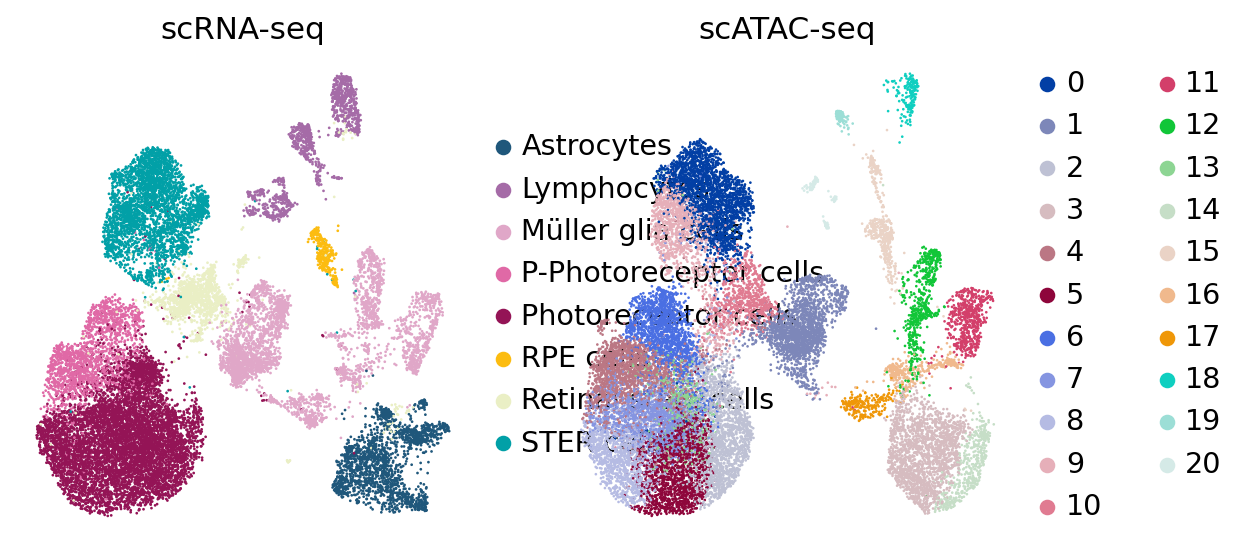

In [56]:
fig, axes = plt.subplots(1,2,figsize=(8,4))
for ad,title,ax_num,c in zip([rna,atac],['scRNA-seq','scATAC-seq'],[0,1],['major_celltype','leiden']):
    ax=sc.pl.embedding(
        ad,
        basis="X_umap",
        color=c,
        title=title,
        frameon=False,
        ncols=1,
        #save='_figure1_celltype.png',
        #use_raw=False,
        wspace=0.5,
        show=False,
        ax=axes[ax_num]
        #palette=sc_color[11:],
    )

In [70]:
##这里纯人眼识别，其实可以开发一个算法的
cluster2annotation = {
     '0': 'STER cells',
     '1': 'Müller glia cells',
     '2': 'Photoreceptor cells',#Germ-cell(Oid)
     '3': 'Astrocytes',#Germ-cell(Oid)
     '4': 'P-Photoreceptor cells',
     '5': 'Photoreceptor cells',
     '6': 'P-Photoreceptor cells',
     '7': 'Photoreceptor cells',
     '8': 'Photoreceptor cells',
     '9': 'STER cells',
     '10': 'Retinal stem cells',#Germ-cell(Oid)
     '11': 'Müller glia cells',
     '12': 'Müller glia cells',
     '13': 'Photoreceptor cells',
     '14': 'Astrocytes',
     '15': 'RPE cells',#Germ
     '16': 'Müller glia cells',#plasma
     '17': 'Müller glia cells',#plasma
     '18': 'Lymphocytes',
     '19': 'Lymphocytes',
     '20': 'Lymphocytes',#Germ-cell(Oid)



}
atac.obs['major_celltype'] = atac.obs['leiden'].map(cluster2annotation).astype('category')

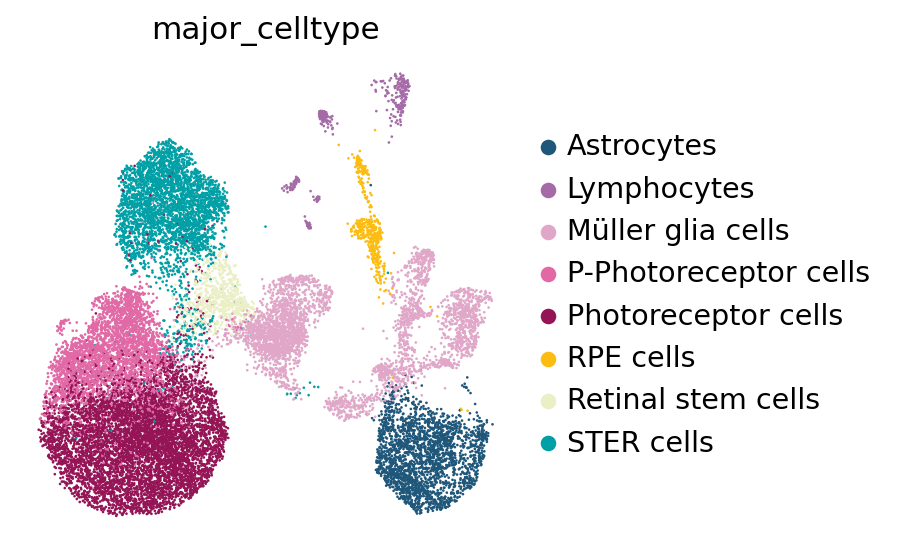

In [72]:
ax=sc.pl.embedding(
    atac,
    basis="X_umap",
    color=['major_celltype'],
    #title='scRNA-seq',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    wspace=0.5,
    show=False,
    palette=sc_color[11:],
)

    using 'X_pca' with n_pcs = 100
Storing dendrogram info using `.uns['dendrogram_major_celltype']`


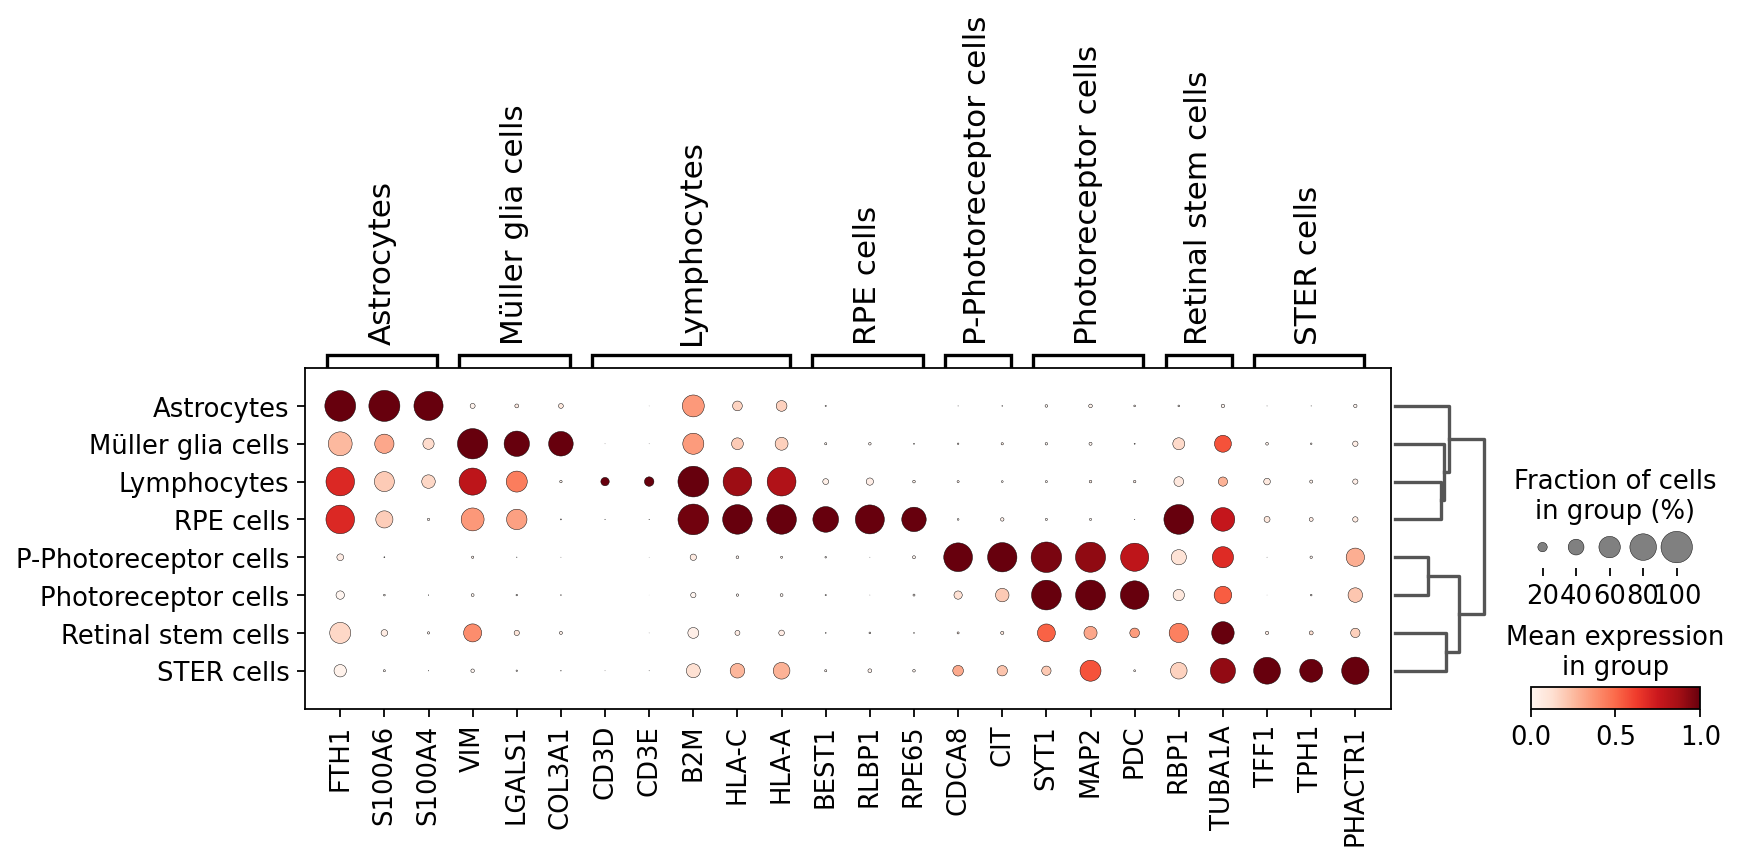

In [73]:
retina_dict={
    'Retinal stem cells':['RBP1','TUBA1A'],
    'Photoreceptor cells':['SYT1','MAP2','PDC'],
    'P-Photoreceptor cells':['CDCA8','CIT',],
    'STER cells':['TFF1','TPH1','PHACTR1'],
    'RPE cells':['BEST1', 'RLBP1', 'RPE65',],
    'Lymphocytes':['CD3D','CD3E','B2M','HLA-C','HLA-A'],
    'Astrocytes':['FTH1','S100A6','S100A4'],
    'Müller glia cells':['VIM','LGALS1','COL3A1'],
}

sc.tl.dendrogram(rna,'major_celltype')
sc.pl.dotplot(rna, retina_dict, 'major_celltype', dendrogram=True,standard_scale='var',show=False)
plt.savefig(current_path+'result/analysis1/retina_celltype.png',dpi=300,bbox_inches='tight')

进一步地，我们还可以提取GLUE的结果，对scRNA-seq与scATAC-seq进行整合

In [74]:
#我们先保存obs.index
rna.obs['obs_index_raw']=rna.obs.index.tolist()
atac.obs['obs_index_raw']=atac.obs.index.tolist()

In [75]:
%%time
#读取数据
#提取GLUE层结果
rna_loc=pd.DataFrame(rna.obsm['X_glue'], index=rna.obs.index)
atac_loc=pd.DataFrame(atac.obsm['X_glue'], index=atac.obs.index)

#对GLUE层进行Pearson系数分析
import numpy as np
import gc
len1=(len(rna_loc)//5000)+1
p_pd=pd.DataFrame(columns=['rank_'+str(i) for i in range(50)])
n_pd=pd.DataFrame(columns=['rank_'+str(i) for i in range(50)])
for j in range(len1):
    c=pd.DataFrame()
    for i in range(len1):
        t1=rna_loc.iloc[5000*(i):5000*(i+1)]
        t2=atac_loc.iloc[5000*(j):5000*(j+1)]
        a=np.corrcoef(t1,t2)[len(t1):,0:len(t1)]
        b=pd.DataFrame(a,index=t2.index,columns=t1.index)  

        c=pd.concat([c,b],axis=1)
        del t1
        del t2
        del a
        del b
        gc.collect()
    for i in range(len(c)):
        t_c=c.iloc[i]
        p_pd.loc[t_c.name]=c.iloc[i].sort_values(ascending=False)[:50].values
        n_pd.loc[t_c.name]=c.iloc[i].sort_values(ascending=False)[:50].index.tolist()
    print('Now epoch is {}, {}/{}'.format(j,j*5000+len(c),len(atac_loc))) 
    del c
    gc.collect()

#寻找最近的细胞，其中depth的灵活调整可以使得配对成功的细胞数变大，同时精度有所下降
def find_neighbor_cell(p_pd,n_pd,depth=10):
    rubish_c=[]
    finish_c=[]
    for d in range(depth):
        p_pd=p_pd.loc[p_pd['rank_{}'.format(d)]>0.9]
        p_pd=p_pd.sort_values('rank_{}'.format(d),ascending=False)
        for i in p_pd.index:
            name=n_pd.loc[i,'rank_{}'.format(d)]
            if name not in rubish_c:
                finish_c.append(i)
                rubish_c.append(name)
            else:
                continue
        p_pd=p_pd.loc[~p_pd.index.isin(finish_c)]
        n_pd=n_pd.loc[~n_pd.index.isin(finish_c)]
    result=pd.DataFrame()
    result['omic_1']=rubish_c
    result['omic_2']=finish_c
    result.index=['cell_{}'.format(i) for i in range(len(result))]
    return result

res_pair=find_neighbor_cell(p_pd,n_pd,depth=20)
res_pair.head()


Now epoch is 0, 5000/21194
Now epoch is 1, 10000/21194
Now epoch is 2, 15000/21194
Now epoch is 3, 20000/21194
Now epoch is 4, 21194/21194
CPU times: user 9min 51s, sys: 18.3 s, total: 10min 10s
Wall time: 9min 34s


omic_1                  omic_2
cell_0  ATTCCTAGTGTATTCG-761  GCCAGCAAGGTACACG-1-772
cell_1  GTCACGGTCTCACCCA-761  GAGATTCTCATTGCCC-1-772
cell_2  CGGAGAACATTCTTCA-761  GGAGAACCATGATCGT-1-772
cell_3  CTCTGGTCAAGACGAC-761  TACCCTGTCCTGACCT-1-772
cell_4  CGAGAAGCATTGCCGG-761  AAGGTTCCATCCATAG-1-772

In [76]:
res_pair.to_csv(current_path+'data/scglue/res_pair_glue.csv')

我构建了一个函数，来为不同组学层进行重命名

In [79]:
def adata_rename(adata,pair,omic_name='omic_1'):
    adata=adata[pair[omic_name].values]
    adata.obs.index=pair.index
    return adata

rna1=adata_rename(rna,res_pair,omic_name='omic_1')
atac1=adata_rename(atac,res_pair,omic_name='omic_2')
rna1,atac1

(View of AnnData object with n_obs × n_vars = 12709 × 2000
     obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Tissue', 'Developmental_Stage', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'domain', 'leiden', 'balancing_weight', 'n_counts', 'major_celltype', 'obs_index_raw'
     var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'End', 'Start', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'ID', 'copy_num_ID', 'coverage', 'db_xref', 'extra_copy_number', 'gbkey', 'gene', 'gene_biotype', 'gene_name', 'dell', 'dispersions', 'dispersions_norm'
     uns: '__scglue__', 'hvg', 'leiden', 'leiden_sizes', 'log1p', 'neighbors', 'pag

此外，我们使用`mudata`包，对两个组学层进行合并，这样我们只需要存一个文件即可

In [80]:
from mudata import MuData

mdata = MuData({'rna': rna1, 'atac': atac1})
mdata

MuData object with n_obs × n_vars = 12709 × 298334
  var:	'n_cells', 'highly_variable', 'chrom', 'chromStart', 'chromEnd'
  2 modalities
    rna:	12709 x 2000
      obs:	'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Tissue', 'Developmental_Stage', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'domain', 'leiden', 'balancing_weight', 'n_counts', 'major_celltype', 'obs_index_raw'
      var:	'gene_ids', 'feature_types', 'genome', 'Accession', 'End', 'Start', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'ID', 'copy_num_ID', 'coverage', 'db_xref', 'extra_copy_number', 'gbkey', 'gene', 'gene_biotype', 'gene_name', 'dell', 'dispersions', 'dispersions_norm'
      uns:	'__scglue__', 'hvg', 'leiden', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'scrublet', 'umap', 'Developmental_Stage_colors', 'leiden_colors', 'dendrogram_leiden', 'rank_genes_groups', 'cosg', 'major_celltype_colors', 'dendrogram_major_celltype'
      obsm:	'X_glue', 'X_pca', 'X_umap'
      varm:	'PCs', 'X_glue'
      layers:	'ambiguous', 'counts', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu'
      obsp:	'connectivities', 'distances'
    atac:	12709 x 296334
      obs:	'Tissue', 'Developmental_Stage', 'SRR', 'nb_features', 'log_nb_features', 'domain', 'balancing_weight', 'leiden', 'major_celltype', 'obs_index_raw'
      var:	'n_cells', 'commonness', 'prop_shared_cells', 'variability_score', 'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'__scglue__', 'neighbors', 'umap', 'Developmental_Stage_colors', 'leiden', 'leiden_colors', 'major_celltype_colors'
      obsm:	'X_glue', 'X_lsi', 'X_umap'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [83]:
mdata.write(current_path+'data/scglue/muomic_anno.h5mu',compression='gzip')

同时，我们保存一下我们的注释结果


In [84]:
atac.write_h5ad(current_path+'data/analysis1/atac_anno.h5ad',compression='gzip')
rna.write_h5ad(current_path+'data/analysis1/rna_anno.h5ad',compression='gzip')

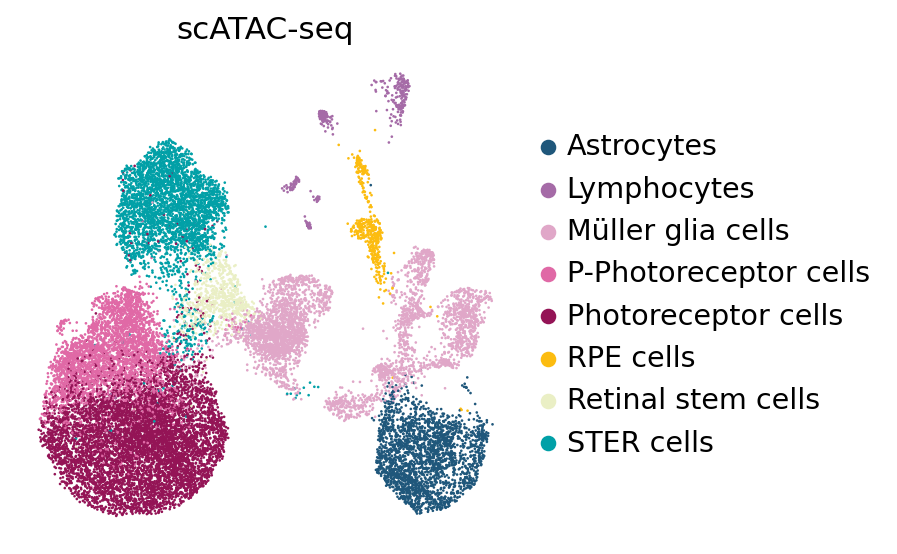

In [87]:
ax=sc.pl.embedding(
    atac,
    basis="X_umap",
    color=['major_celltype'],
    title='scATAC-seq',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    wspace=0.5,
    show=False,
    #palette=sc_color[11:],
)
ax.savefig(current_path+'result/analysis1/scATAC_celltype.png',dpi=300,bbox_inches='tight')

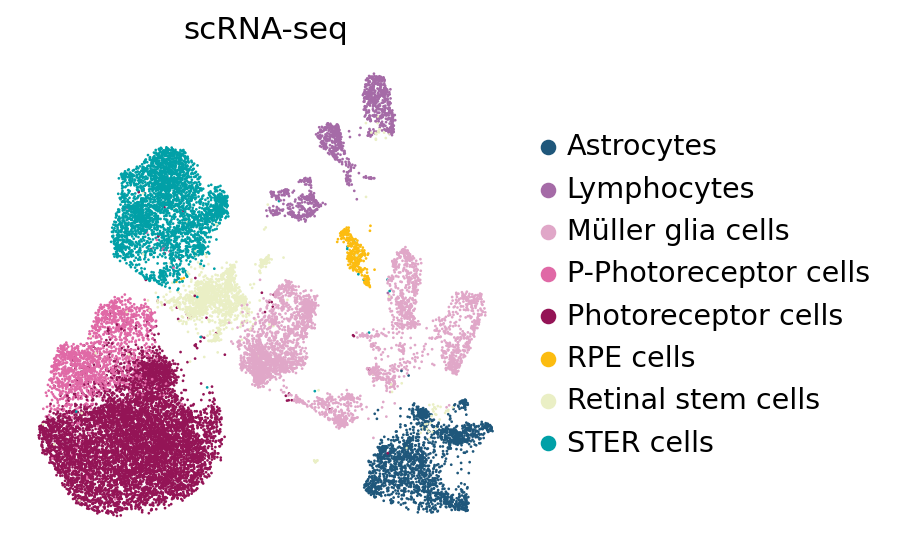

In [88]:
ax=sc.pl.embedding(
    rna,
    basis="X_umap",
    color=['major_celltype'],
    title='scRNA-seq',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    wspace=0.5,
    show=False,
    #palette=sc_color[11:],
)
ax.savefig(current_path+'result/analysis1/scRNA_celltype.png',dpi=300,bbox_inches='tight')

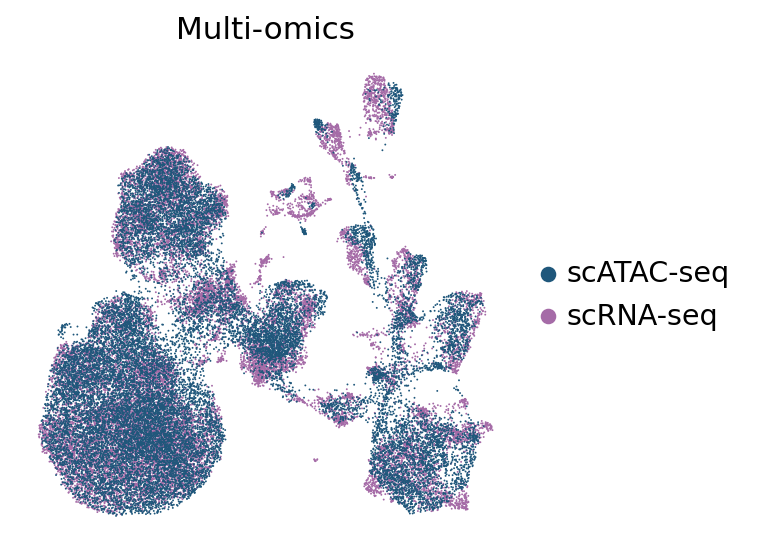

In [94]:
ax=sc.pl.embedding(
    combined,
    basis="X_umap",
    color=['domain'],
    title='Multi-omics',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    wspace=0.5,
    show=False,
    palette=sc_color[11:],
)
ax.savefig(current_path+'result/analysis1/multi_omics.png',dpi=300,bbox_inches='tight')

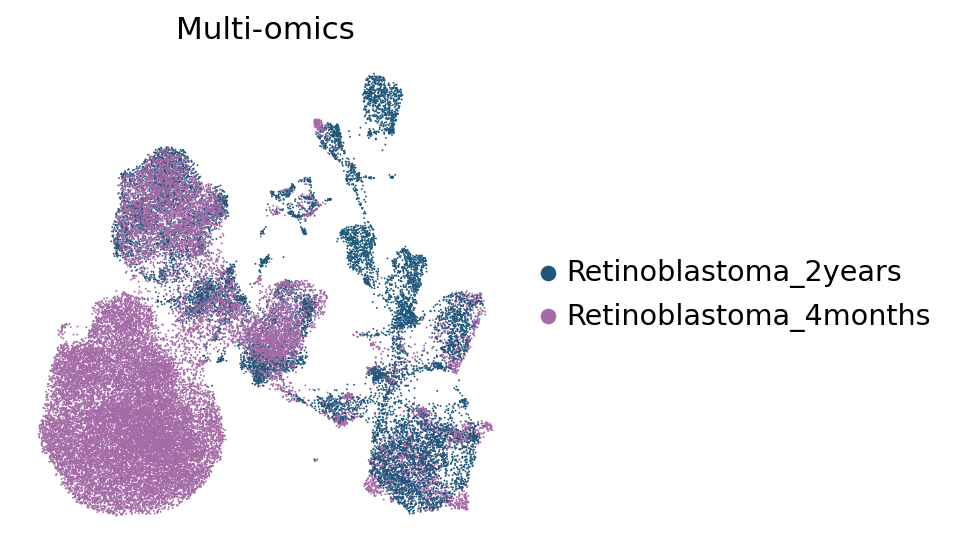

In [95]:
ax=sc.pl.embedding(
    combined,
    basis="X_umap",
    color=['Developmental_Stage'],
    title='Multi-omics',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    wspace=0.5,
    show=False,
    palette=sc_color[11:],
)
ax.savefig(current_path+'result/analysis1/multi_Developmental_Stage.png',dpi=300,bbox_inches='tight')